The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-beta0


# Asynchronous Random Search
:label:`sec_rs_async`

As we have seen in the previous :numref:`sec_api_hpo`, we might have to wait
hours or even days before random search returns a good hyperparameter
configuration, because of the expensive evaluation of hyperparameter
configurations. In practice, we have often access to a pool of resources such as
multiple GPUs on the same machine or multiple machines with a single GPU. This
begs the question: *How do we efficiently distribute random search?*

In general, we distinguish between synchronous and asynchronous parallel
hyperparameter optimization (see :numref:`distributed_scheduling`). In the
synchronous setting, we wait for all concurrently running trials to finish,
before we start the next batch. Consider configuration spaces that contain
hyperparameters such as the number of filters or number of layers of a deep
neural network. Hyperparameter configurations that contain a larger number of 
layers of filters will naturally take more time to finish, and all other trials
in the same batch will have to wait at synchronisation points (grey area in
:numref:`distributed_scheduling`) before we can continue the optimization
process.

In the asynchronous setting we immediately schedule a new trial as soon as resources
become available. This will optimally exploit our resources, since we can avoid any
synchronisation overhead. For random search, each new hyperparameter configuration
is chosen independently of all others, and in particular without exploiting
observations from any prior evaluation. This means we can trivially parallelize random
search asynchronously. This is not straight-forward with more sophisticated methods
that make decision based on previous observations (see :numref:`sec_sh_async`).
While we need access to more resources than in the sequential setting, asynchronous
random search exhibits a linear speed-up, in that a certain performance is reached
$K$ times faster if $K$ trials can be run in parallel. 


![Distributing the hyperparameter optimization process either synchronously or asynchronously. Compared to the sequential setting, we can reduce the overall wall-clock time while keep the total compute constant. Synchronous scheduling might lead to idling workers in the case of stragglers.](http://d2l.ai/_images/distributed_scheduling.svg)
:label:`distributed_scheduling`

In this notebook, we will look at asynchronous random search that, where trials are
executed in multiple python processes on the same machine. Distributed job scheduling
and execution is difficult to implement from scratch. We will use *Syne Tune*
:cite:`salinas-automl22`, which provides us with a simple interface for asynchronous
HPO. Syne Tune is designed to be run with different execution back-ends, and the
interested reader is invited to study its simple APIs in order to learn more about
distributed HPO.


In [1]:
import logging
from d2l import torch as d2l

logging.basicConfig(level=logging.INFO)
from syne_tune import StoppingCriterion, Tuner
from syne_tune.backend.python_backend import PythonBackend
from syne_tune.config_space import loguniform, randint
from syne_tune.experiments import load_experiment
from syne_tune.optimizer.baselines import RandomSearch

INFO:root:SageMakerBackend is not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[extra]'


AWS dependencies are not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[aws]'
or (for everything)
   pip install 'syne-tune[extra]'
AWS dependencies are not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[aws]'
or (for everything)
   pip install 'syne-tune[extra]'


INFO:root:Ray Tune schedulers and searchers are not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[raytune]'
or (for everything)
   pip install 'syne-tune[extra]'


## Objective Function

First, we have to define a new objective function such that it now returns the
performance back to Syne Tune via the `report` callback.


In [2]:
def hpo_objective_lenet_synetune(learning_rate, batch_size, max_epochs):
    from syne_tune import Reporter
    from d2l import torch as d2l

    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    trainer = d2l.HPOTrainer(max_epochs=1, num_gpus=1)
    data = d2l.FashionMNIST(batch_size=batch_size)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    report = Reporter()
    for epoch in range(1, max_epochs + 1):
        if epoch == 1:
            # Initialize the state of Trainer
            trainer.fit(model=model, data=data)
        else:
            trainer.fit_epoch()
        validation_error = trainer.validation_error().cpu().detach().numpy()
        report(epoch=epoch, validation_error=float(validation_error))

Note that the `PythonBackend` of Syne Tune requires dependencies to be imported
inside the function definition.

## Asynchronous Scheduler

First, we define the number of workers that evaluate trials concurrently. We
also need to specify how long we want to run random search, by defining an
upper limit on the total wall-clock time.


In [3]:
n_workers = 2  # Needs to be <= the number of available GPUs

max_wallclock_time = 12 * 60  # 12 minutes

Next, we state which metric we want to optimize and whether we want to minimize or
maximize this metric. Namely, `metric` needs to correspond to the argument name
passed to the `report` callback.


In [4]:
mode = "min"
metric = "validation_error"

We use the configuration space from our previous example. In Syne Tune, this
dictionary can also be used to pass constant attributes to the training script.
We make use of this feature in order to pass `max_epochs`. Moreover, we specify
the first configuration to be evaluated in `initial_config`.


In [5]:
config_space = {
    "learning_rate": loguniform(1e-2, 1),
    "batch_size": randint(32, 256),
    "max_epochs": 10,
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128,
}

Next, we need to specify the back-end for job executions. Here we just consider
the distribution on a local machine where parallel jobs are executed as
sub-processes. However, for large scale HPO, we could run this also on a cluster
or cloud environment, where each trial consumes a full instance.


In [6]:
trial_backend = PythonBackend(
    tune_function=hpo_objective_lenet_synetune,
    config_space=config_space,
)

We can now create the scheduler for asynchronous random search, which is similar
in behaviour to our `BasicScheduler` from :numref:`sec_api_hpo`.


In [7]:
scheduler = RandomSearch(
    config_space,
    metric=metric,
    mode=mode,
    points_to_evaluate=[initial_config],
)

INFO:syne_tune.optimizer.schedulers.fifo:max_resource_level = 10, as inferred from config_space


INFO:syne_tune.optimizer.schedulers.fifo:Master random_seed = 946352797


Syne Tune also features a `Tuner`, where the main experiment loop and
bookkeeping is centralized, and interactions between scheduler and back-end are
mediated.


In [8]:
stop_criterion = StoppingCriterion(max_wallclock_time=max_wallclock_time)

tuner = Tuner(
    trial_backend=trial_backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=n_workers,
    print_update_interval=int(max_wallclock_time * 0.6),
)

Let us run our distributed HPO experiment. According to our stopping criterion,
it will run for about 12 minutes.


In [9]:
tuner.run()

INFO:syne_tune.tuner:results of trials will be saved on /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030


INFO:root:Detected 4 GPUs


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.1 --batch_size 128 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/tune_function --tune_function_hash dde03bdf362adcf8bbb4712728beab77 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/0/checkpoints


INFO:syne_tune.tuner:(trial 0) - scheduled config {'learning_rate': 0.1, 'batch_size': 128, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.318682094722803 --batch_size 117 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/tune_function --tune_function_hash dde03bdf362adcf8bbb4712728beab77 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/1/checkpoints


INFO:syne_tune.tuner:(trial 1) - scheduled config {'learning_rate': 0.318682094722803, 'batch_size': 117, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 0 completed.


INFO:syne_tune.tuner:Trial trial_id 1 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.015024865831360435 --batch_size 219 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/tune_function --tune_function_hash dde03bdf362adcf8bbb4712728beab77 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/2/checkpoints


INFO:syne_tune.tuner:(trial 2) - scheduled config {'learning_rate': 0.015024865831360435, 'batch_size': 219, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.0608755813501688 --batch_size 185 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/tune_function --tune_function_hash dde03bdf362adcf8bbb4712728beab77 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/3/checkpoints


INFO:syne_tune.tuner:(trial 3) - scheduled config {'learning_rate': 0.0608755813501688, 'batch_size': 185, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 2 completed.


INFO:syne_tune.tuner:Trial trial_id 3 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.07178825012495035 --batch_size 210 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/tune_function --tune_function_hash dde03bdf362adcf8bbb4712728beab77 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/4/checkpoints


INFO:syne_tune.tuner:(trial 4) - scheduled config {'learning_rate': 0.07178825012495035, 'batch_size': 210, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.04505137281173426 --batch_size 184 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/tune_function --tune_function_hash dde03bdf362adcf8bbb4712728beab77 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/5/checkpoints


INFO:syne_tune.tuner:(trial 5) - scheduled config {'learning_rate': 0.04505137281173426, 'batch_size': 184, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 4 completed.


INFO:syne_tune.tuner:Trial trial_id 5 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.10454825110262035 --batch_size 225 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/tune_function --tune_function_hash dde03bdf362adcf8bbb4712728beab77 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/6/checkpoints


INFO:syne_tune.tuner:(trial 6) - scheduled config {'learning_rate': 0.10454825110262035, 'batch_size': 225, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.15842669824312153 --batch_size 161 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/tune_function --tune_function_hash dde03bdf362adcf8bbb4712728beab77 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/7/checkpoints


INFO:syne_tune.tuner:(trial 7) - scheduled config {'learning_rate': 0.15842669824312153, 'batch_size': 161, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 6 completed.


INFO:syne_tune.tuner:Trial trial_id 7 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.5315329654761515 --batch_size 176 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/tune_function --tune_function_hash dde03bdf362adcf8bbb4712728beab77 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/8/checkpoints


INFO:syne_tune.tuner:(trial 8) - scheduled config {'learning_rate': 0.5315329654761515, 'batch_size': 176, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.053431592930178545 --batch_size 35 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/tune_function --tune_function_hash dde03bdf362adcf8bbb4712728beab77 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/9/checkpoints


INFO:syne_tune.tuner:(trial 9) - scheduled config {'learning_rate': 0.053431592930178545, 'batch_size': 35, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 8 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.6544859121038635 --batch_size 236 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/tune_function --tune_function_hash dde03bdf362adcf8bbb4712728beab77 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/10/checkpoints


INFO:syne_tune.tuner:(trial 10) - scheduled config {'learning_rate': 0.6544859121038635, 'batch_size': 236, 'max_epochs': 10}


INFO:syne_tune.tuner:tuning status (last metric is reported)
 trial_id     status  iter  learning_rate  batch_size  max_epochs  epoch  validation_error  worker-time
        0  Completed    10       0.100000         128          10     10          0.267108    78.840169
        1  Completed    10       0.318682         117          10     10          0.206585    75.779138
        2  Completed    10       0.015025         219          10     10          0.899873    70.464898
        3  Completed    10       0.060876         185          10     10          0.420098    72.947269
        4  Completed    10       0.071788         210          10     10          0.468162    70.169655
        5  Completed    10       0.045051         184          10     10          0.899518    69.075731
        6  Completed    10       0.104548         225          10     10          0.339679    71.186420
        7  Completed    10       0.158427         161          10     10          0.249619    72.079897
   

INFO:syne_tune.tuner:Trial trial_id 9 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.012886119513082982 --batch_size 76 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/tune_function --tune_function_hash dde03bdf362adcf8bbb4712728beab77 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/11/checkpoints


INFO:syne_tune.tuner:(trial 11) - scheduled config {'learning_rate': 0.012886119513082982, 'batch_size': 76, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 10 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.3028503008418779 --batch_size 52 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/tune_function --tune_function_hash dde03bdf362adcf8bbb4712728beab77 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/12/checkpoints


INFO:syne_tune.tuner:(trial 12) - scheduled config {'learning_rate': 0.3028503008418779, 'batch_size': 52, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 11 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.6969419761013845 --batch_size 88 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/tune_function --tune_function_hash dde03bdf362adcf8bbb4712728beab77 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/13/checkpoints


INFO:syne_tune.tuner:(trial 13) - scheduled config {'learning_rate': 0.6969419761013845, 'batch_size': 88, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 12 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.5850212844606077 --batch_size 190 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/tune_function --tune_function_hash dde03bdf362adcf8bbb4712728beab77 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/14/checkpoints


INFO:syne_tune.tuner:(trial 14) - scheduled config {'learning_rate': 0.5850212844606077, 'batch_size': 190, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 13 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.030852668774306934 --batch_size 194 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/tune_function --tune_function_hash dde03bdf362adcf8bbb4712728beab77 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/15/checkpoints


INFO:syne_tune.tuner:(trial 15) - scheduled config {'learning_rate': 0.030852668774306934, 'batch_size': 194, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 14 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.04931495897503216 --batch_size 99 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/tune_function --tune_function_hash dde03bdf362adcf8bbb4712728beab77 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/16/checkpoints


INFO:syne_tune.tuner:(trial 16) - scheduled config {'learning_rate': 0.04931495897503216, 'batch_size': 99, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 15 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.07148902300062492 --batch_size 60 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/tune_function --tune_function_hash dde03bdf362adcf8bbb4712728beab77 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030/17/checkpoints


INFO:syne_tune.tuner:(trial 17) - scheduled config {'learning_rate': 0.07148902300062492, 'batch_size': 60, 'max_epochs': 10}


INFO:syne_tune.stopping_criterion:reaching max wallclock time (720), stopping there.


INFO:syne_tune.tuner:Stopping trials that may still be running.


INFO:syne_tune.tuner:Tuning finished, results of trials can be found on /home/ci/syne-tune/python-entrypoint-2023-08-14-16-57-37-030


--------------------
Resource summary (last result is reported):
 trial_id     status  iter  learning_rate  batch_size  max_epochs  epoch  validation_error  worker-time
        0  Completed    10       0.100000         128          10   10.0          0.267108    78.840169
        1  Completed    10       0.318682         117          10   10.0          0.206585    75.779138
        2  Completed    10       0.015025         219          10   10.0          0.899873    70.464898
        3  Completed    10       0.060876         185          10   10.0          0.420098    72.947269
        4  Completed    10       0.071788         210          10   10.0          0.468162    70.169655
        5  Completed    10       0.045051         184          10   10.0          0.899518    69.075731
        6  Completed    10       0.104548         225          10   10.0          0.339679    71.186420
        7  Completed    10       0.158427         161          10   10.0          0.249619    72.079897

The logs of all evaluated hyperparameter configurations are stored for further
analysis. At any time during the tuning job, we can easily get the results
obtained so far and plot the incumbent trajectory.


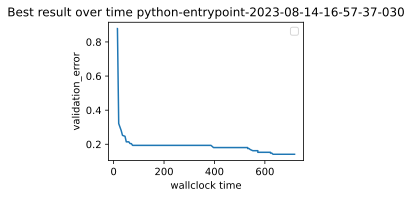

In [10]:
d2l.set_figsize()
tuning_experiment = load_experiment(tuner.name)
tuning_experiment.plot()

## Visualize the Asynchronous Optimization Process

Below we visualize how the learning curves of every trial (each color in the plot represents a trial) evolve during the
asynchronous optimization process. At any point in time, there are as many trials
running concurrently as we have workers. Once a trial finishes, we immediately
start the next trial, without waiting for the other trials to finish. Idle time
of workers is reduced to a minimum with asynchronous scheduling.


Text(0, 0.5, 'objective function')

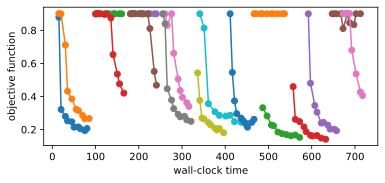

In [11]:
d2l.set_figsize([6, 2.5])
results = tuning_experiment.results

for trial_id in results.trial_id.unique():
    df = results[results["trial_id"] == trial_id]
    d2l.plt.plot(
        df["st_tuner_time"],
        df["validation_error"],
        marker="o"
    )

d2l.plt.xlabel("wall-clock time")
d2l.plt.ylabel("objective function")

## Summary

We can reduce the waiting time for random search substantially by distribution
trials across parallel resources. In general, we distinguish between synchronous
scheduling and asynchronous scheduling. Synchronous scheduling means that we
sample a new batch of hyperparameter configurations once the previous batch
finished. If we have a stragglers - trials that takes more time to finish than
other trials - our workers need to wait at synchronization points. Asynchronous
scheduling evaluates a new hyperparameter configurations as soon as resources
become available, and, hence, ensures that all workers are busy at any point in
time. While random search is easy to distribute asynchronously and does not
require any change of the actual algorithm, other methods require some additional
modifications.

## Exercises

1. Consider the `DropoutMLP` model implemented in :numref:`sec_dropout`, and used in Exercise 1 of :numref:`sec_api_hpo`.
    1. Implement an objective function `hpo_objective_dropoutmlp_synetune` to be used with Syne Tune. Make sure that your function reports the validation error after every epoch.
    2. Using the setup of Exercise 1 in :numref:`sec_api_hpo`, compare random search to Bayesian optimization. If you use SageMaker, feel free to use Syne Tune's benchmarking facilities in order to run experiments in parallel. Hint: Bayesian optimization is provided as `syne_tune.optimizer.baselines.BayesianOptimization`.
    3. For this exercise, you need to run on an instance with at least 4 CPU cores. For one of the methods used above (random search, Bayesian optimization), run experiments with `n_workers=1`, `n_workers=2`, `n_workers=4`, and compare results (incumbent trajectories). At least for random search, you should observe linear scaling with respect to the number of workers. Hint: For robust results, you may have to average over several repetitions each.
2. *Advanced*. The goal of this exercise is to implement a new scheduler in Syne Tune.
    1. Create a virtual environment containing both the [d2lbook](https://github.com/d2l-ai/d2l-en/blob/master/INFO.md#installation-for-developers) and [syne-tune](https://syne-tune.readthedocs.io/en/latest/getting_started.html) sources.
    2. Implement the `LocalSearcher` from Exercise 2 in :numref:`sec_api_hpo` as a new searcher in Syne Tune. Hint: Read [this tutorial](https://syne-tune.readthedocs.io/en/latest/tutorials/developer/README.html). Alternatively, you may follow this [example](https://syne-tune.readthedocs.io/en/latest/examples.html#launch-hpo-experiment-with-home-made-scheduler).
    3. Compare your new `LocalSearcher` with `RandomSearch` on the `DropoutMLP` benchmark.


[Discussions](https://discuss.d2l.ai/t/12093)
